<a href="https://colab.research.google.com/github/tkazusa/keras_practice/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style transfer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Input, MaxPooling2D, Conv2DTranspose, UpSampling2D, Lambda, BatchNormalization, Add, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 変換ネットワークを構築するencoder・decoder 関数の定義

In [0]:
def residual_block(input_ts):
    """ResidualBlockの構築する関数"""
    x = Conv2D(
        128, (3, 3), strides=1, padding='same'
    )(input_ts)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    return Add()([x, input_ts])

def build_encoder_decoder(input_shape=(224, 224, 3)):
    """変換用ネットワークの構築"""

    # Encoder部分
    input_ts = Input(shape=input_shape, name='input')

    # 入力を[0, 1]の範囲に正規化
    x = Lambda(lambda a: a/255.)(input_ts)

    x = Conv2D(32, (9, 9), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # ResidualBlockを5ブロック追加
    for _ in range(5):
        x = residual_block(x)

    # Decoder部分
    x = Conv2DTranspose(
            64, (3, 3), strides=2, padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(3, (9, 9), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # 出力値が[0, 255]になるようにスケール変換
    gen_out = Lambda(lambda a: (a + 1)*127.5)(x)

    model_gen = Model(
        inputs=[input_ts], 
        outputs=[gen_out]
    )

    return model_gen

input_shape = (224, 224, 3)

# 変換ネットワークの構築
model_gen = build_encoder_decoder(input_shape=input_shape)

### 学習用ネットワークの構築

In [0]:
from tensorflow.python.keras.applications.vgg16 import VGG16


# 学習済みモデルVGG16の呼び出し
vgg16 = VGG16()

# 重みパラメータを学習させない設定をする
for layer in vgg16.layers:
    layer.trainable = False

# VGG16のための入力値を正規化する関数
def norm_vgg16(x):
        """RGB->BGR変換と近似的に中心化をおこなう関数"""
        return (x[:, :, :, ::-1]  - 120)/255.
    
# 特徴量を抽出する層の名前を定義
style_layer_names = (
    'block1_conv2', 
    'block2_conv2', 
    'block3_conv3', 
    'block4_conv3'
)
contents_layer_names = ('block3_conv3',)

# 中間層の出力を保持するためのリスト
style_outputs_gen = []
contents_outputs_gen = []

input_gen = model_gen.output  # 変換ネットワークの出力を入力とする
z = Lambda(norm_vgg16)(input_gen)  # 入力値の正規化
for layer in vgg16.layers:
    z = layer(z)  # VGG16の層を積み上げてネットワークを再構築
    if layer.name in style_layer_names:
        # スタイル特徴量抽出用の中間層の出力を追加
        style_outputs_gen.append(z)
    if layer.name in contents_layer_names:
        # コンテンツ特徴量抽出用の中間層の出力を追加
        contents_outputs_gen.append(z)

# モデルを定義
model = Model(
      inputs=model_gen.input,
      outputs=style_outputs_gen + contents_outputs_gen
)

### スタイルの手本となる画像の読み込み

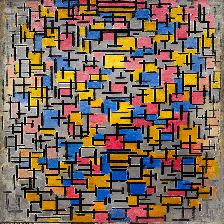

In [0]:
input_size = input_shape[:2]

# スタイル画像の読み込み
img_sty = load_img(
    'img/style/Piet_Mondrian_Composition.png', 
    target_size=input_size
)

# スタイル画像の表示
img_sty

### 手本となる画像のスタイル特徴量の抽出

In [0]:
# 読み込んだ画像をnumpy.ndarrayに変換
img_arr_sty = np.expand_dims(img_to_array(img_sty), axis=0)

# 入力層の定義
input_sty = Input(shape=input_shape, name='input_sty')

style_outputs = []  # 中間層の出力を保持するリスト
x = Lambda(norm_vgg16)(input_sty)
for layer in vgg16.layers:
    x = layer(x)
    if layer.name in style_layer_names:
        style_outputs.append(x)

# スタイルの手本となる画像を入力して、特徴量を出力するモデルを定義
model_sty = Model(
    inputs=input_sty, 
    outputs=style_outputs
)

# 手本画像から正解データとなる特徴量を抽出
y_true_sty = model_sty.predict(img_arr_sty)

# コンテンツ画像の読み込み
img_con = load_img(
    'img/context/fa076ee97e8f2c40.jpg', 
    target_size=input_size
)

# スタイル画像の表示
img_con

### 手本となる画像のコンテンツ特徴量の抽出用ネットワーク構築

In [0]:
# 入力層の定義
input_con = Input(shape=input_shape, name='input_con')

contents_outputs = [] # 中間層の出力を保持するリスト
y = Lambda(norm_vgg16)(input_con)
for layer in vgg16.layers:
    y = layer(y)
    if layer.name in contents_layer_names:
        contents_outputs.append(y)

# コンテンツの手本画像を入力して、特徴量を出力するモデルを定義
model_con = Model(
    inputs=input_con, 
    outputs=contents_outputs
)

#### 画像読み込み用の関数定義

In [0]:
# 画像ファイル読み込み用のラッパー関数定義
def load_imgs(img_paths, target_size=(224, 224)):
    """画像ファイルのパスのリストから、配列のバッチを返す"""
    _load_img = lambda x: img_to_array(
        load_img(x, target_size=target_size)
    )
    img_list = [
        np.expand_dims(_load_img(img_path), axis=0)
        for img_path in img_paths
    ]
    return np.concatenate(img_list, axis=0)

### ジェネレータ用の関数定義

In [0]:
def train_generator(img_paths, batch_size, model, y_true_sty, shuffle=True, epochs=None):
    """学習データを生成するジェネレータ"""
    n_samples = len(img_paths)
    indices = list(range(n_samples))
    steps_per_epoch = math.ceil(n_samples / batch_size)
    img_paths = np.array(img_paths)
    cnt_epoch = 0
    while True:
        cnt_epoch += 1
        if shuffle:
            np.random.shuffle(indices)
        for i in range(steps_per_epoch):
            start = batch_size*i
            end = batch_size*(i + 1)
            X = load_imgs(img_paths[indices[start:end]])
            batch_size_act = X.shape[0]
            y_true_sty_t = [
                np.repeat(feat, batch_size_act, axis=0)
                for feat in y_true_sty
            ]
            # コンテンツ特徴量の抽出
            y_true_con = model.predict(X)
            yield (X,  y_true_sty_t + [y_true_con])
        if epochs is not None:
            if cnt_epoch >= epochs:
                raise StopIteration
                
                
import glob


# 入力画像ファイルのパスを取得
path_glob = os.path.join('img/context/*.jpg')
img_paths = glob.glob(path_glob)

# バッチサイズとエポック数の設定
batch_size = 2
epochs = 10

# ジェネレータを生成
gen = train_generator(
    img_paths, 
    batch_size, 
    model_con,
    y_true_sty,
    epochs=epochs
)

### 損失関数

In [0]:
from tensorflow.python.keras import backend as K


def feature_loss(y_true, y_pred):
    """コンテンツ特徴量の損失関数"""
    norm = K.prod(K.cast(K.shape(y_true)[1:], 'float32'))
    return K.sum(
        K.square(y_pred - y_true), axis=(1, 2, 3)
    )/norm
  
  
def gram_matrix(X):
    """グラム行列の算出"""
    X_sw = K.permute_dimensions(
        X, (0, 3, 2, 1)
    )  # 軸の入れ替え
    s = K.shape(X_sw)
    new_shape = (s[0], s[1], s[2]*s[3])
    X_rs = K.reshape(X_sw, new_shape)
    X_rs_t = K.permute_dimensions(
        X_rs, (0, 2, 1)
    )  # 行列の転置
    dot = K.batch_dot(X_rs, X_rs_t)  # 内積の計算
    norm = K.prod(K.cast(s[1:], 'float32'))
    return dot/norm

def style_loss(y_true, y_pred):
    """スタイル用の損失関数定義"""
    return K.sum(
        K.square(
            gram_matrix(y_pred) - gram_matrix(y_true)
        ),
        axis=(1, 2)
    )

### デルや結果を保存するディレクトリの準備

In [0]:
import datetime


# モデルや結果を保存するディレクトリの準備
dt = datetime.datetime.now()
dir_log = 'model/{:%y%m%d_%H%M%S}'.format(dt)
dir_weights = 'model/{:%y%m%d_%H%M%S}/weights'.format(dt)
dir_trans = 'model/{:%y%m%d_%H%M%S}/img_trans'.format(dt)

os.makedirs(dir_log, exist_ok=True)
os.makedirs(dir_weights, exist_ok=True)
os.makedirs(dir_trans, exist_ok=True)

### italicized text*Total Variation Regularizerの定義と正則化項の追加

In [0]:
# Total Variation Regularizerの定義
def TVRegularizer(x, weight=1e-6, beta=1.0, input_size=(224, 224)):
    delta = 1e-8
    h, w = input_size
    d_h = K.square(x[:, :h - 1, :w - 1, :] - x[:, 1:, :w - 1, :])
    d_w = K.square(x[:, :h - 1, :w - 1, :] - x[:, :h - 1, 1:, :])
    return weight * K.mean(K.sum(K.pow(d_h + d_w + delta, beta/2.)))

# 正則化項を追加
use_tvr = True
if use_tvr:
    gen_output_layer = model_gen.layers[-1]
    tv_loss = TVRegularizer(gen_output_layer.output)
    gen_output_layer.add_loss(tv_loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### モデルのコンパイル

In [0]:
from tensorflow.keras.optimizers import Adadelta


# モデルのコンパイル
model.compile(
      optimizer=Adadelta(),
      loss=[
            style_loss, 
            style_loss, 
            style_loss, 
            style_loss, 
            feature_loss
        ],
      loss_weights=[1.0, 1.0, 1.0, 1.0, 3.0]
)

### モデルの学習

In [0]:
import pickle


# 学習中に画風変換の途中経過を確認するため
# 読み込んだ画像をnumpy.ndarrayに変換
img_test = load_img(
    'img/test/building.jpg', 
    target_size=input_size
)
img_arr_test = img_to_array(img_test)
img_arr_test = np.expand_dims(
    img_to_array(img_test), 
    axis=0
)

# エポックごとのバッチ数の計算
steps_per_epoch = math.ceil(len(img_paths)/batch_size)

iters_verbose = 1000
iters_save_img = 1000
iters_save_model = steps_per_epoch

# 学習実施
# 学習にはGPUを利用して、数時間かかる
now_epoch = 0
losses = []
path_tmp = 'epoch_{}_iters_{}_loss_{:.2f}_{}'
for i, (x_train, y_train) in enumerate(gen):
    
    if i % steps_per_epoch == 0:
        now_epoch += 1
    
    # 学習
    loss =  model.train_on_batch(x_train, y_train)
    losses.append(loss)

    # 学習経過の表示
    if i % iters_verbose == 0:
        print(
            'epoch:{}, iters:{}, loss:{:.3f}'.format(
                now_epoch, i, loss[0]
            )
        )

    # 画像の保存
    if i % iters_save_img == 0 :
        pred = model_gen.predict(img_arr_test)
        img_pred = array_to_img(pred.squeeze())
        path_trs_img = path_tmp.format(
            now_epoch, i, loss[0], '.jpg'
        )
        img_pred.save(
            os.path.join(
                dir_trans, 
                path_trs_img
            )
        )
        print('# image saved:{}'.format(path_trs_img))
    
    # モデル、損失の保存
    if i % iters_save_model == 0 :
        model.save(
            os.path.join(
                dir_weights, 
                path_tmp.format(
                    now_epoch, i, loss[0], '.h5'
                )
            )
        )
        path_loss = os.path.join(dir_log, 'loss.pkl')
        with open(path_loss, 'wb') as f:
            pickle.dump(losses, f)

epoch:1, iters:0, loss:5438.507
# image saved:epoch_1_iters_0_loss_5438.51_.jpg
epoch:1, iters:1000, loss:474.331
# image saved:epoch_1_iters_1000_loss_474.33_.jpg
epoch:1, iters:2000, loss:425.014
# image saved:epoch_1_iters_2000_loss_425.01_.jpg
epoch:1, iters:3000, loss:371.839
# image saved:epoch_1_iters_3000_loss_371.84_.jpg
epoch:1, iters:4000, loss:402.565
# image saved:epoch_1_iters_4000_loss_402.56_.jpg
epoch:1, iters:5000, loss:397.621
# image saved:epoch_1_iters_5000_loss_397.62_.jpg
epoch:2, iters:6000, loss:368.506
# image saved:epoch_2_iters_6000_loss_368.51_.jpg
epoch:2, iters:7000, loss:360.682
# image saved:epoch_2_iters_7000_loss_360.68_.jpg
epoch:2, iters:8000, loss:336.338
# image saved:epoch_2_iters_8000_loss_336.34_.jpg
epoch:2, iters:9000, loss:373.120
# image saved:epoch_2_iters_9000_loss_373.12_.jpg
epoch:2, iters:10000, loss:353.627
# image saved:epoch_2_iters_10000_loss_353.63_.jpg
epoch:3, iters:11000, loss:340.505
# image saved:epoch_3_iters_11000_loss_340.

### 変換前の画像表示

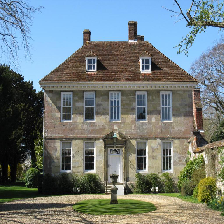

In [0]:
# 変換前の画像の表示
img_test

#### 画像の変換

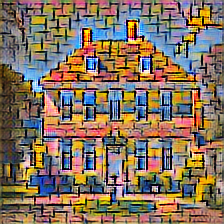

In [0]:
# モデルの適用
pred = model_gen.predict(img_arr_test)

# 変換後の画像の表示
img_pred = array_to_img(pred.squeeze())
img_pred